___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
# You can install torchmeterics using: pip install torchmetrics

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [2]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)


Device available: cpu


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [3]:
# Loading TIFF images for Super-resolution
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
    
    # Get the number of samples in the dataset
    def __len__(self):
        return len(self.filenames)

    # Get the sample at the given index
    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        # Load images
        high_res = Image.open(high_res_path)
        low_res = Image.open(low_res_path)

        # Resize low-res to 128x128 (ensuring correct input size)
        low_res = low_res.resize((128, 128), Image.BICUBIC)

        # Apply transformations
        if self.transform:
            high_res = self.transform(high_res)
            low_res = self.transform(low_res)

        return low_res, high_res  # Returning input-output pairs

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform)

# Function to create data loader
def create_loader(dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset size
dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)


Number of images in the dataset: 240


___
### Define a super-resolution network

#### Here, I have defined a trivial network, which has only two layers and no activation function. We are essentially doing linear filtering.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + x)

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = F.relu(self.fc1(y), inplace=True)
        y = torch.sigmoid(self.fc2(y))
        return x * y.view(b, c, 1, 1)

class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(gating_channels, inter_channels, 1, bias=False),
            nn.BatchNorm2d(inter_channels)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, 1, bias=False),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ResAttUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_filters=32):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, base_filters, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            ResidualBlock(base_filters),
            SEBlock(base_filters)
        )
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_filters, base_filters*2, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            ResidualBlock(base_filters*2),
            SEBlock(base_filters*2)
        )
        self.pool2 = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_filters*2, base_filters*4, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            ResidualBlock(base_filters*4),
            SEBlock(base_filters*4)
        )
        # Decoder
        self.up2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, 2, stride=2)
        self.att2 = AttentionGate(in_channels=base_filters*2,
                                  gating_channels=base_filters*2,
                                  inter_channels=base_filters)
        self.dec2 = nn.Sequential(
            ResidualBlock(base_filters*4),
            SEBlock(base_filters*4)
        )
        self.up1 = nn.ConvTranspose2d(base_filters*4, base_filters, 2, stride=2)
        self.att1 = AttentionGate(in_channels=base_filters,
                                  gating_channels=base_filters,
                                  inter_channels=base_filters//2)
        self.dec1 = nn.Sequential(
            ResidualBlock(base_filters*2),
            SEBlock(base_filters*2)
        )
        # Final conv
        self.final = nn.Conv2d(base_filters*2, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        d2 = self.up2(b)
        e2_att = self.att2(e2, d2)
        d2 = torch.cat([d2, e2_att], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        e1_att = self.att1(e1, d1)
        d1 = torch.cat([d1, e1_att], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)

___
### Create a function to execute training. Note, we will call this function later.

In [5]:
def train_model(model, opt, criterion, train_loader, num_epoch):
    avg_train_losses = []

    for epoch in range(num_epoch):  # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0

        for i, (x_tr_batch, y_tr_batch) in enumerate(train_loader):  # Loop over mini-batches
            x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

            # Step 1: Upsample input to 256×256 using bicubic interpolation
            x_up = F.interpolate(x_tr_batch, scale_factor=2, mode='bicubic', align_corners=False)

            # Step 2: Feed upsampled input to model
            y_hat = model(x_up)

            # Backprop
            opt.zero_grad()
            loss = criterion(y_hat, y_tr_batch)
            loss.backward()
            opt.step()

            total_train_loss += loss.item()

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_losses.append(avg_train_loss)

    # Plot training loss
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch + 1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Epoch 1, Iteration 10, Loss: 0.005525
Epoch 1, Iteration 20, Loss: 0.003224
Epoch 1, Iteration 30, Loss: 0.001485
Epoch 1, Iteration 40, Loss: 0.001587
Epoch 2, Iteration 10, Loss: 0.003470
Epoch 2, Iteration 20, Loss: 0.002213
Epoch 2, Iteration 30, Loss: 0.001279
Epoch 2, Iteration 40, Loss: 0.001148
Epoch 3, Iteration 10, Loss: 0.003581
Epoch 3, Iteration 20, Loss: 0.001709
Epoch 3, Iteration 30, Loss: 0.000897
Epoch 3, Iteration 40, Loss: 0.000828
Epoch 4, Iteration 10, Loss: 0.001519
Epoch 4, Iteration 20, Loss: 0.000644
Epoch 4, Iteration 30, Loss: 0.002490
Epoch 4, Iteration 40, Loss: 0.000811
Epoch 5, Iteration 10, Loss: 0.000728
Epoch 5, Iteration 20, Loss: 0.002175
Epoch 5, Iteration 30, Loss: 0.001110
Epoch 5, Iteration 40, Loss: 0.000699
Epoch 6, Iteration 10, Loss: 0.001052
Epoch 6, Iteration 20, Loss: 0.001190
Epoch 6, Iteration 30, Loss: 0.002237
Epoch 6, Iteration 40, Loss: 0.000848
Epoch 7, Iteration 10, Loss: 0.001823
Epoch 7, Iteration 20, Loss: 0.000866
Epoch 7, Ite

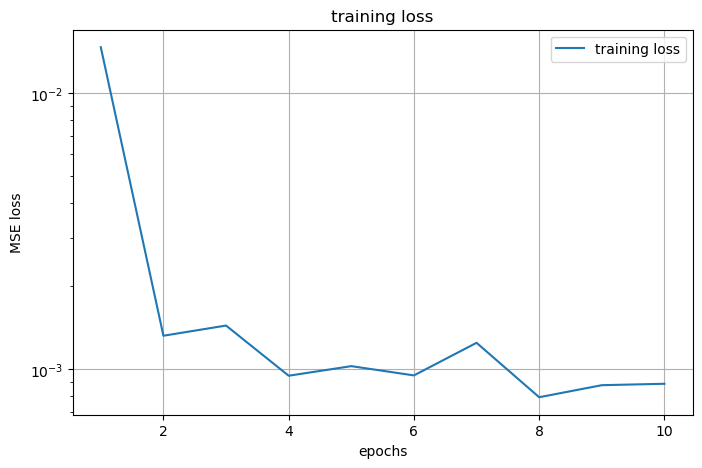

In [6]:
# Hyperparameters
batch_size = 5
lr = 1e-3
num_epoch = 10

# DataLoader, model, optimizer, and loss
train_loader = create_loader(train_dataset, batch_size)
model = ResAttUNet(in_ch=1, out_ch=1, base_filters=32).to(device)
opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Train the model
train_model(model, opt, criterion, train_loader, num_epoch)

___
### Apply it one of the validation image

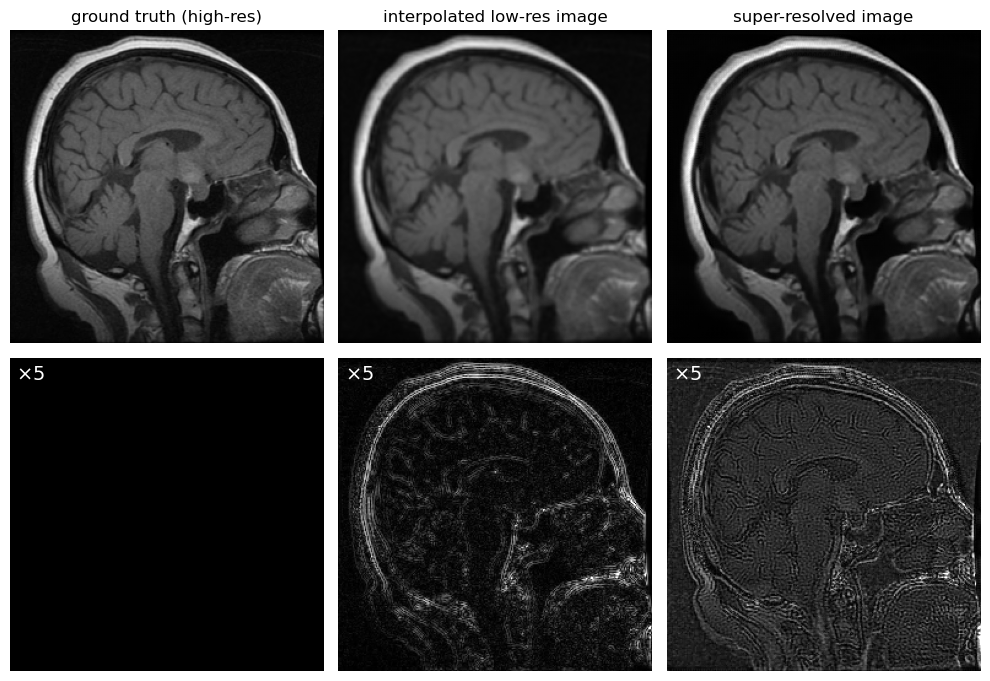

In [7]:
# Create the dataset for validation images
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform)

# Load one (low-res, high-res) image pair from validation dataset and move it to the dedvice
val_low_res, val_high_res = val_dataset[1]  # Input (128x128), Ground truth (256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Upsample low-resolution image to 256x256 for both model input and error visualization
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)

# Apply the trained model to super-resolve the interpolated low-res image
val_super_res = model(val_low_res_interpolated.unsqueeze(0)).detach().squeeze(0)  # Remove batch dimension

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the interpolated version for error maps
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_super_res_np = val_super_res.squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('ground truth (high-res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('interpolated low-res image')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('super-resolved image')
ax[0, 2].axis('off')

# Error maps
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()


### Compute PSNR and SSIM over the entire validation dataset

In [8]:
# Initialize metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Accumulators
total_psnr_interpolated = 0
total_psnr_super_resolved = 0
total_ssim_interpolated = 0
total_ssim_super_resolved = 0
num_samples = len(val_dataset)

# Loop over validation set
for i in range(num_samples):
    val_low_res, val_high_res = val_dataset[i]
    val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

    # Compute data range dynamically
    data_range = val_high_res.max() - val_high_res.min()
    ssim_metric.data_range = data_range

    # Upsample low-res image
    val_low_res_up = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False)
    val_high_res = val_high_res.unsqueeze(0)  # Add batch dim
    val_super_res = model(val_low_res_up).detach()

    # PSNR
    psnr_interp = psnr_metric(val_low_res_up, val_high_res).item()
    psnr_sr = psnr_metric(val_super_res, val_high_res).item()

    # SSIM (data_range is now set in metric initialization)
    ssim_interp = ssim_metric(val_low_res_up, val_high_res).item()
    ssim_sr = ssim_metric(val_super_res, val_high_res).item()

    # Accumulate
    total_psnr_interpolated += psnr_interp
    total_psnr_super_resolved += psnr_sr
    total_ssim_interpolated += ssim_interp
    total_ssim_super_resolved += ssim_sr

# Averages
avg_psnr_interp = total_psnr_interpolated / num_samples
avg_psnr_sr = total_psnr_super_resolved / num_samples
avg_ssim_interp = total_ssim_interpolated / num_samples
avg_ssim_sr = total_ssim_super_resolved / num_samples

# Print results
print(f'Average PSNR (interpolated): {avg_psnr_interp:.2f} dB')
print(f'Average PSNR (super-resolved): {avg_psnr_sr:.2f} dB')
print(f'Average SSIM (interpolated): {avg_ssim_interp:.4f}')
print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')

Average PSNR (interpolated): 30.81 dB
Average PSNR (super-resolved): 27.82 dB
Average SSIM (interpolated): 0.9056
Average SSIM (super-resolved): 0.8837
